# Formula-based models with bambi

In this session we will learn how to use the Python library [`bambi`]()
to fit formula-based Bayesian regression models.

## Imports

First we import all the python packages that we will need.

In [1]:
import arviz as az
import bambi as bmb
import polars as pl
import numpy as np
from matplotlib import pyplot as plt

## Hello world example

To demonstrate how bambi works we’ll start with a very simple linear
regression model, where the variate $y$ is an unconstrained real number
that is predicted by a single covariate $b$.

We can simulate some measurements from this model like this

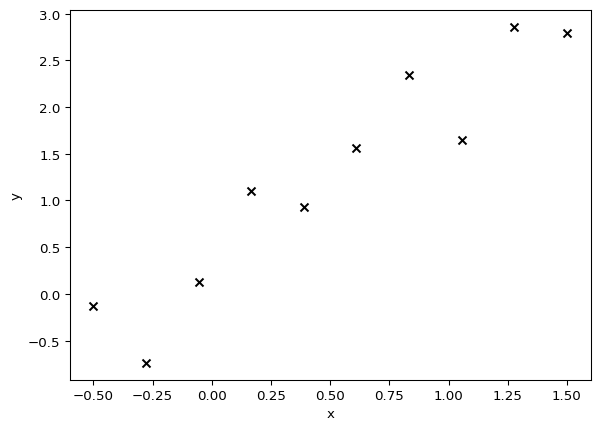

In [2]:
A_HW = 0.2
B_HW = 1.7
SIGMA_HW = 0.5

def simulate_hw(x: float, a,  b: float, sigma: float):
    "Simulate a measurement given covariate x, weight b and error sd sigma."
    yhat = a + x * b
    return yhat + np.random.normal(0, scale=sigma)

x_hw = np.linspace(-0.5, 1.5, 10)
y_hw = np.array([simulate_hw(x_i, A_HW, B_HW, SIGMA_HW) for x_i in x_hw])
data_hw = pl.DataFrame({"x": x_hw, "y": y_hw})

f, ax = plt.subplots()
ax.scatter(x_hw, y_hw, marker="x", color="black", label="simulated observation")
ax.set(xlabel="x", ylabel="y")
plt.show()

We can implement this model using bambi with the very simple formula \`y
~ x”

In [3]:
formula_hw = "y ~ x"
model_hw = bmb.Model(formula_hw, data=data_hw.to_pandas())
model_hw

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 10
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2493, sigma: 3.7125)
            x ~ Normal(mu: 0.0, sigma: 4.5788)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.169)

To perform Bayesian inference, we use the model object’s `fit` method:

In [4]:
results_hw = model_hw.fit()
az.summary(results_hw)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.

## More relevant example

As a second example, we will fit the model introduced in yesterday’s
session.

Suppose we have five strains that we want to evaluate for their ability
to ferment a protein. To test these abilities we perform 4 biological
replicates per strain, each of which we test 5 times.

In [5]:
TRUE_PRODUCTIVITY = {
    "a": 0.49,
    "b": 0.51,
    "c": 0.53,
    "d": 0.55,
    "e": 0.57
}
N_BIOLOGICAL_REPLICATE = 4
N_TECHNICAL_REPLICATE = 5
BIOLOGICAL_VARIATION = 0.1
TECHNICAL_VARIATION = 0.01


def simulate_fermentation(prod, bio_effect, tv):
    return np.exp(np.log(prod) + bio_effect + np.random.normal(0, scale=tv))

rows = []
for strain, prod in TRUE_PRODUCTIVITY.items():
    for row_br in range(N_BIOLOGICAL_REPLICATE):
        bio_effect = np.random.normal(0, BIOLOGICAL_VARIATION)
        for row_tr in range(N_TECHNICAL_REPLICATE):
            rows.append(
                {
                  "strain": strain,
                  "biological_replicate": f"{strain}-{row_br}",
                  "technical_replicate": f"{strain}-{row_br}-{row_tr}",
                  "y": simulate_fermentation(
                      prod,
                      bio_effect,
                      TECHNICAL_VARIATION,
                  ),
                }
            )
data_bio = pl.from_records(rows).with_columns(log_y=np.log(pl.col("y")))
data_bio.head()

To specify the model we do more or less the same as before, except that
this time our formula is
`"log_y ~ 0 + strain + (1|biological_replicate)"` indicating a model
with no global intercept (this is what the `0` at the start of the right
hand side does) and separate intercept parameters per strain and per
biological replicate, with the biological replicate intercepts modelled
hierarchically.

Since our model has slightly unusual scales, we also supply some custom
priors. Note the nested structure for the `"1|biological_replicate"`
prior.

In [6]:
formula_bio = "log_y ~ 0 + strain + (1|biological_replicate)"
bio_var_prior = bmb.Prior("HalfNormal", sigma=0.2)
br_effect_prior = bmb.Prior("Normal", mu=0.0, sigma=bio_var_prior)
priors = {
    "strain": bmb.Prior("Normal", mu=-0.7, sigma=0.3),
    "sigma": bmb.Prior("HalfNormal", sigma=0.01),
    "1|biological_replicate": br_effect_prior,
}
model_bio = bmb.Model(formula_bio, data=data_bio.to_pandas(), priors=priors)
model_bio

       Formula: log_y ~ 0 + strain + (1|biological_replicate)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            strain ~ Normal(mu: -0.7, sigma: 0.3)
        
        Group-level effects
            1|biological_replicate ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.2))
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 0.01)

Fitting and inspecting goes the same as before, but to save space we
avoid printing the `1|biological_replicate` parameters. This is a handy
arviz trick!

In [7]:
results_bio = model_bio.fit()
az.summary(
    results_bio,
    var_names="~1|biological_replicate",
    filter_vars="regex"
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, strain, 1|biological_replicate_sigma, 1|biological_replicate_offset]

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.

Now we can check that the strain intercepts roughly match the simulation
inputs.

In [8]:
prod_mean = np.exp(results_bio.posterior["strain"]).mean(dim=["chain", "draw"])
pl.DataFrame(
    {
        "strain": TRUE_PRODUCTIVITY.keys(),
        "true_productivity": TRUE_PRODUCTIVITY.values(),
        "posterior_mean": prod_mean.values
    }
)

> **Exercise**
>
> Try to find the probability, according to our model, that strain “a”
> is less productive than strain “c”.